In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv("df_with_clip_text_image_and_quality.csv")
df.shape, df.head(3)

((11565, 1918),
    Type_x  Age_x            Breed1Name Breed2Name  Gender_x Color1Name  \
 0       2      3                 Tabby        NaN         1      Black   
 1       2      1  Domestic Medium Hair        NaN         1      Black   
 2       1      1           Mixed Breed        NaN         1      Brown   
 
   Color2Name Color3Name  MaturitySize_x  FurLength_x  ...    State  \
 0      White        NaN               1            1  ...  41326.0   
 1      Brown        NaN               2            2  ...  41401.0   
 2      White        NaN               2            2  ...  41326.0   
 
                           RescuerID  VideoAmt_y  \
 0  8480853f516546f6cf33aa88cd76c379         0.0   
 1  3082c7125d8fb66f7dd4bff4192c8b14         0.0   
 2  fa90fa5b1ee11c86938398b60abc32cb         0.0   
 
                                        Description_y  PhotoAmt_y  \
 0  Nibble is a 3+ month old ball of cuteness. He ...         1.0   
 1  I just found it alone yesterday near my apar

In [3]:
# If both exist, keep AdoptionSpeed_x and drop _y
if "AdoptionSpeed_x" in df.columns and "AdoptionSpeed_y" in df.columns:
    df["AdoptionSpeed"] = df["AdoptionSpeed_x"]
    df = df.drop(columns=["AdoptionSpeed_x", "AdoptionSpeed_y"])

In [4]:
df["AdoptionSpeed"].head()

0    2
1    0
2    3
3    2
4    2
Name: AdoptionSpeed, dtype: int64

In [5]:
target_col = "AdoptionSpeed"
y = df[target_col].to_numpy()
pet_ids = df["PetID"].to_numpy()

In [6]:
# 1. CLIP text features
text_cols = [c for c in df.columns if c.startswith("clip_text_")]

# 2. CLIP image embeddings
clip_img_cols = [c for c in df.columns if c.startswith("clip_img_")]

# 3. Image quality features (Phase 1)
img_quality_cols = [
    c for c in df.columns 
    if (
        c.startswith("img_") or 
        c.startswith("meta_") or 
        "brightness" in c.lower() or 
        "blur" in c.lower() or 
        "bbox" in c.lower() or
        "has_cage" in c or
        "has_indoor" in c or
        "has_outdoor" in c
    )
    # and not CLIP embedding cols
    and not c.startswith("clip_img_")
]

# 4. Image feature group = CLIP image + quality
img_cols = clip_img_cols + img_quality_cols

# 5. Tabular features = numeric columns excluding ID, target, text, and image
exclude = set(
    ["PetID", target_col] + text_cols + img_cols
)
tab_cols = [
    c for c in df.columns
    if c not in exclude and np.issubdtype(df[c].dtype, np.number)
]

print("Tabular cols:", len(tab_cols))
print("Text cols   :", len(text_cols))
print("Image cols  :", len(img_cols))
print("   ├─ CLIP image:", len(clip_img_cols))
print("   └─ quality   :", len(img_quality_cols))

Tabular cols: 41
Text cols   : 50
Image cols  : 1807
   ├─ CLIP image: 512
   └─ quality   : 1295


In [7]:
X_T   = df[tab_cols].to_numpy()
X_X   = df[text_cols].to_numpy()
X_I   = df[img_cols].to_numpy()
X_TX  = np.concatenate([X_T, X_X], axis=1)
X_TXI = np.concatenate([X_T, X_X, X_I], axis=1)

X_T.shape, X_X.shape, X_I.shape, X_TX.shape, X_TXI.shape

((11565, 41), (11565, 50), (11565, 1807), (11565, 91), (11565, 1898))

In [8]:
idx = np.arange(len(df))

idx_train, idx_val = train_test_split(
    idx,
    test_size=0.2,
    stratify=y,
    random_state=42
)

y_train = y[idx_train]
y_val   = y[idx_val]

X_T_train,   X_T_val   = X_T[idx_train],   X_T[idx_val]
X_X_train,   X_X_val   = X_X[idx_train],   X_X[idx_val]
X_I_train,   X_I_val   = X_I[idx_train],   X_I[idx_val]
X_TX_train,  X_TX_val  = X_TX[idx_train],  X_TX[idx_val]
X_TXI_train, X_TXI_val = X_TXI[idx_train], X_TXI[idx_val]

In [9]:
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights="quadratic")

def evaluate_model(name, y_true, y_pred, verbose=True):
    acc = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    qwk = quadratic_weighted_kappa(y_true, y_pred)
    
    if verbose:
        print(f"\n=== {name} ===")
        print(f"Accuracy   : {acc:.4f}")
        print(f"Macro F1   : {macro_f1:.4f}")
        print(f"QWK        : {qwk:.4f}")
    
    return {
        "model": name,
        "accuracy": acc,
        "macro_f1": macro_f1,
        "qwk": qwk
    }

def make_xgb():
    return XGBClassifier(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=7,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        objective="multi:softprob",
        num_class=5,
        random_state=42,
        n_jobs=-1
    )

In [ ]:
results = []

# 1. Tabular only (T)
xgb_T = make_xgb()
xgb_T.fit(X_T_train, y_train)
y_pred_T = xgb_T.predict(X_T_val)
results.append(evaluate_model("XGB_T (tab only)", y_val, y_pred_T))

# 2. Text only (X; CLIP text)
xgb_X = make_xgb()
xgb_X.fit(X_X_train, y_train)
y_pred_X = xgb_X.predict(X_X_val)
results.append(evaluate_model("XGB_X (CLIP text only)", y_val, y_pred_X))

# 3. Image only (I; CLIP image + quality)
xgb_I = make_xgb()
xgb_I.fit(X_I_train, y_train)
y_pred_I = xgb_I.predict(X_I_val)
results.append(evaluate_model("XGB_I (CLIP image + quality)", y_val, y_pred_I))

# 4. Tabular + Text (T+X)
xgb_TX = make_xgb()
xgb_TX.fit(X_TX_train, y_train)
y_pred_TX = xgb_TX.predict(X_TX_val)
results.append(evaluate_model("XGB_TX (tab + CLIP text)", y_val, y_pred_TX))

# 5. Full early fusion (T+X+I)
xgb_TXI = make_xgb()
xgb_TXI.fit(X_TXI_train, y_train)
y_pred_TXI = xgb_TXI.predict(X_TXI_val)
results.append(evaluate_model("XGB_TXI (tab + CLIP text + CLIP image + quality)", y_val, y_pred_TXI))

ablation_df = (
    pd.DataFrame(results)
    .sort_values("qwk", ascending=False)
    .reset_index(drop=True)
)
ablation_df

Interpretation (business-friendly)

Tabular data is the strongest single predictor, meaning structured attributes like age, breed, vaccination, sterilization, color, and metadata explain most of adoption speed.

Text alone is the weakest modality, because many pet descriptions are short, duplicated, or noisy.

Images alone beat text, especially after adding quality features, suggesting that visual cues (pose, clarity, presence of cage/outdoor environment) truly matter.

Adding text to tabular improves the model → because description tone and keywords add nuance.

Full fusion (TXI) is better than any individual modality, though still not optimal.

This ablation study shows each modality adds some unique signal.

In [17]:
proba_TX  = xgb_TX.predict_proba(X_TX_val)
proba_I   = xgb_I.predict_proba(X_I_val)
proba_TXI = xgb_TXI.predict_proba(X_TXI_val)

fusion_results = []

alphas = np.arange(0.0, 1.01, 0.1)  # weight for T+X
betas  = np.arange(0.0, 1.01, 0.1)  # weight for I

for alpha in alphas:
    for beta in betas:
        gamma = 1.0 - alpha - beta
        if gamma < 0 or gamma > 1:
            continue

        proba_blend = alpha * proba_TX + beta * proba_I + gamma * proba_TXI
        y_pred_blend = proba_blend.argmax(axis=1)

        name = f"LateFusion_CLIP_a{alpha:.1f}_b{beta:.1f}_g{gamma:.1f}"
        res = evaluate_model(name, y_val, y_pred_blend, verbose=False)
        res["alpha_TX"]  = alpha
        res["beta_I"]    = beta
        res["gamma_TXI"] = gamma
        fusion_results.append(res)

fusion_df = (
    pd.DataFrame(fusion_results)
    .sort_values("qwk", ascending=False)
    .reset_index(drop=True)
)
fusion_df.head(10)

,model,accuracy,macro_f1,qwk,alpha_TX,beta_I,gamma_TXI
0,LateFusion_CLIP_a0.5_b0.3_g0.2,0.466494,0.385071,0.452032,0.5,0.3,0.2
1,LateFusion_CLIP_a0.5_b0.1_g0.4,0.465197,0.385704,0.451016,0.5,0.1,0.4
2,LateFusion_CLIP_a0.5_b0.2_g0.3,0.467791,0.386886,0.449959,0.5,0.2,0.3
3,LateFusion_CLIP_a0.4_b0.5_g0.1,0.460441,0.379906,0.449698,0.4,0.5,0.1
4,LateFusion_CLIP_a0.4_b0.4_g0.2,0.464764,0.383081,0.449330,0.4,0.4,0.2
5,LateFusion_CLIP_a0.5_b0.4_g0.1,0.467791,0.385742,0.448859,0.5,0.4,0.1
6,LateFusion_CLIP_a0.4_b0.3_g0.3,0.463035,0.382035,0.448749,0.4,0.3,0.3
7,LateFusion_CLIP_a0.6_b0.3_g0.1,0.470385,0.390676,0.448569,0.6,0.3,0.1
8,LateFusion_CLIP_a0.4_b0.1_g0.5,0.464332,0.379390,0.448211,0.4,0.1,0.5
9,LateFusion_CLIP_a0.5_b0.5_g0.0,0.461306,0.380852,0.446039,0.5,0.5,0.0


In [18]:
best_fusion = fusion_df.iloc[0].copy()
best_fusion["model"] = (
    f"LateFusion_best (α_TX={best_fusion['alpha_TX']:.2f}, "
    f"β_I={best_fusion['beta_I']:.2f}, γ_TXI={best_fusion['gamma_TXI']:.2f})"
)

cols = ["model", "accuracy", "macro_f1", "qwk"]

final_leaderboard = (
    pd.concat(
        [ablation_df[cols], best_fusion[cols].to_frame().T],
        ignore_index=True
    )
    .sort_values("qwk", ascending=False)
    .reset_index(drop=True)
)

final_leaderboard

,model,accuracy,macro_f1,qwk
0,"LateFusion_best (α_TX=0.50, β_I=0.30, γ_TXI=0.20)",0.466494,0.385071,0.452032
1,XGB_TXI (tab + CLIP text + CLIP image + quality),0.417207,0.323589,0.406618
2,XGB_TX (tab + CLIP text),0.435365,0.36149,0.397689
3,XGB_T (tab only),0.423692,0.352638,0.392364
4,XGB_I (CLIP image + quality),0.39559,0.307148,0.35457
5,XGB_X (CLIP text only),0.383052,0.325015,0.270575


## FEATURE IMPORTANCE ANALYSIS

In [28]:
from scipy.stats import ttest_ind

def analyze_continuous(df, col, fast=[0,1], slow=[3,4]):
    temp = df.copy()
    temp = temp[temp["AdoptionSpeed"].isin(fast + slow)]

    fast_vals = temp[temp["AdoptionSpeed"].isin(fast)][col].dropna()
    slow_vals = temp[temp["AdoptionSpeed"].isin(slow)][col].dropna()

    plt.figure(figsize=(6,4))
    sns.boxplot(x=temp["AdoptionSpeed"].isin(fast).map({True:"Fast", False:"Slow"}), 
                y=temp[col],
                palette="Set2")
    plt.title(f"{col} vs Adoption Outcome")
    plt.ylabel(col)
    plt.xlabel("Adoption Outcome")
    plt.show()

    tstat, p = ttest_ind(fast_vals, slow_vals, equal_var=False)

    print(f"\n=== {col.upper()} Analysis ===")
    print(f"Fast mean = {fast_vals.mean():.3f}")
    print(f"Slow mean = {slow_vals.mean():.3f}")
    print(f"T-test p-value = {p:.5f}")

    if p < 0.05:
        print(f"➡ '{col}' shows a significant difference between fast and slow adoptions.")
    else:
        print(f"➡ '{col}' does NOT show a statistically significant difference.")


/var/folders/1p/9r_vrx2x03zgfvsn15jzs9b00000gn/T/ipykernel_61797/3640070993.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=temp["AdoptionSpeed"].isin(fast).map({True:"Fast", False:"Slow"}),


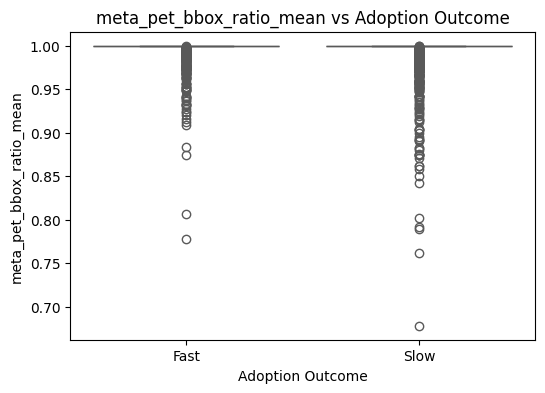


=== META_PET_BBOX_RATIO_MEAN Analysis ===
Fast mean = 0.998
Slow mean = 0.998
T-test p-value = 0.56552
➡ 'meta_pet_bbox_ratio_mean' does NOT show a statistically significant difference.


In [34]:
analyze_continuous(df, "meta_pet_bbox_ratio_mean")

/var/folders/1p/9r_vrx2x03zgfvsn15jzs9b00000gn/T/ipykernel_61797/3640070993.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=temp["AdoptionSpeed"].isin(fast).map({True:"Fast", False:"Slow"}),


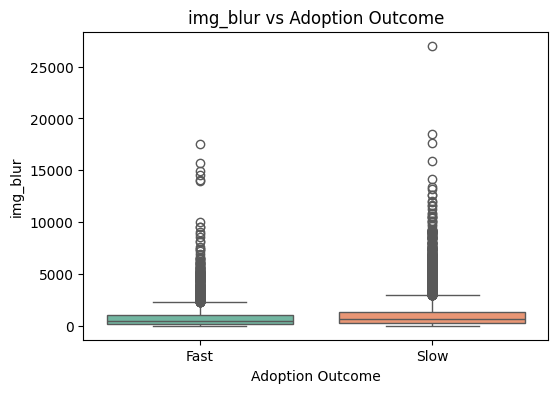


=== IMG_BLUR Analysis ===
Fast mean = 893.683
Slow mean = 1188.732
T-test p-value = 0.00000
➡ 'img_blur' shows a significant difference between fast and slow adoptions.


In [30]:
analyze_continuous(df, "img_blur")

/var/folders/1p/9r_vrx2x03zgfvsn15jzs9b00000gn/T/ipykernel_61797/3640070993.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=temp["AdoptionSpeed"].isin(fast).map({True:"Fast", False:"Slow"}),


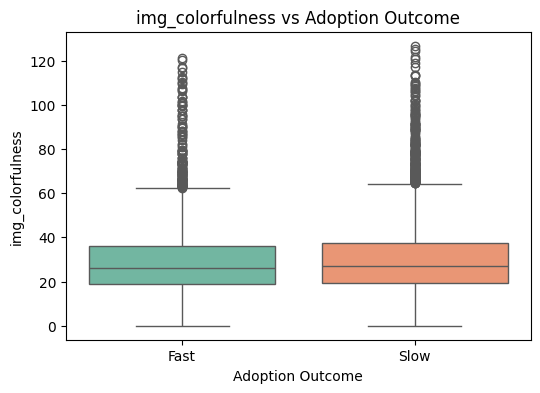


=== IMG_COLORFULNESS Analysis ===
Fast mean = 29.711
Slow mean = 30.177
T-test p-value = 0.23196
➡ 'img_colorfulness' does NOT show a statistically significant difference.


In [31]:
analyze_continuous(df, "img_colorfulness")

/var/folders/1p/9r_vrx2x03zgfvsn15jzs9b00000gn/T/ipykernel_61797/3640070993.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=temp["AdoptionSpeed"].isin(fast).map({True:"Fast", False:"Slow"}),


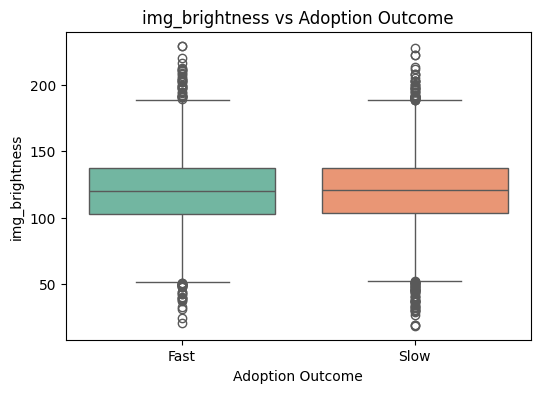


=== IMG_BRIGHTNESS Analysis ===
Fast mean = 120.041
Slow mean = 120.379
T-test p-value = 0.60846
➡ 'img_brightness' does NOT show a statistically significant difference.


In [32]:
analyze_continuous(df, "img_brightness")

## CLIP zero-shot labeling

In [35]:
import numpy as np
import pandas as pd

# This is the big file: tabular + CLIP text + CLIP image + quality
df = pd.read_csv("df_with_clip_text_image_and_quality.csv")

# Find CLIP image embedding columns
clip_img_cols = [c for c in df.columns if c.startswith("clip_img_")]
len(clip_img_cols), clip_img_cols[:5]

(512, ['clip_img_0', 'clip_img_1', 'clip_img_2', 'clip_img_3', 'clip_img_4'])

In [36]:
from sentence_transformers import SentenceTransformer

clip_model = SentenceTransformer("clip-ViT-B-32", device="cpu")  

/opt/anaconda3/envs/petfusion/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [37]:
label_spec = {
    # Environment
    "zs_env_outdoor": "a photo of a pet outdoors on grass",
    "zs_env_indoor": "a photo of a pet indoors in a house",
    "zs_env_cage": "a photo of a pet in a cage or kennel",
    "zs_env_sofa": "a photo of a pet relaxing on a sofa or couch",
    "zs_env_shelter": "a photo of a pet inside an animal shelter kennel",

    # Human presence
    "zs_human_with_pet": "a person hugging or holding a pet",
    "zs_human_no_person": "a photo of a pet alone with no people",

    # Pet pose / framing
    "zs_pose_sitting": "a dog sitting and looking at the camera",
    "zs_pose_standing": "a dog standing on all four legs",
    "zs_pose_lying": "a dog lying down and resting",
    "zs_frame_closeup": "a close up portrait photo of a pet face",
    "zs_frame_fullbody": "a full body photo of a pet",

    # Emotion / sentiment
    "zs_emotion_happy": "a happy smiling dog",
    "zs_emotion_sad": "a sad lonely dog",
    "zs_emotion_scared": "a scared anxious dog",

    # Background / quality
    "zs_bg_clean": "a pet in front of a simple clean background",
    "zs_bg_cluttered": "a pet in a messy cluttered room with many objects",
    "zs_quality_bright": "a bright well lit professional photo of a pet",
    "zs_quality_dark": "a dark low light blurry photo of a pet"
}

In [ ]:
label_names = list(label_spec.keys())
label_texts = [label_spec[k] for k in label_names]

# Text embeddings, L2-normalized
label_emb = clip_model.encode(
    label_texts,
    convert_to_numpy=True,
    normalize_embeddings=True
)
label_emb.shape  # (num_labels, 512)

In [ ]:
X_img = df[clip_img_cols].to_numpy(dtype="float32")  # (N, 512)

# L2 normalize rows
norms = np.linalg.norm(X_img, axis=1, keepdims=True)
norms[norms == 0] = 1e-8
X_img = X_img / norms

In [ ]:
# scores: (N, num_labels)
scores = X_img @ label_emb.T
scores.shape

In [ ]:
for j, name in enumerate(label_names):
    df[name] = scores[:, j]

df[[ "PetID", "AdoptionSpeed" ] + label_names[:5]].head()

In [ ]:
from scipy.stats import ttest_ind

def analyze_zs_feature(df, col, fast_labels=(0,1), slow_labels=(3,4)):
    temp = df.copy()
    temp = temp[temp["AdoptionSpeed"].isin(fast_labels + slow_labels)]

    temp["is_fast"] = temp["AdoptionSpeed"].isin(fast_labels).astype(int)

    fast_vals = temp.loc[temp["is_fast"] == 1, col].dropna()
    slow_vals = temp.loc[temp["is_fast"] == 0, col].dropna()

    tstat, pval = ttest_ind(fast_vals, slow_vals, equal_var=False)

    print(f"\n=== {col} Analysis ===")
    print(f"Fast mean = {fast_vals.mean():.3f}")
    print(f"Slow mean = {slow_vals.mean():.3f}")
    print(f"T-test p-value = {pval:.5f}")

    if pval < 0.05:
        print(f"→ '{col}' shows a statistically significant difference between fast and slow adoptions.")
    else:
        print(f"→ '{col}' does NOT show a statistically significant difference.")

In [ ]:
analyze_zs_feature(df, "zs_emotion_happy")
analyze_zs_feature(df, "zs_bg_clean")
analyze_zs_feature(df, "zs_quality_dark")
analyze_zs_feature(df, "zs_human_with_pet")

In [ ]:
out_path = "df_with_clip_zero_shot_labels.csv"
df.to_csv(out_path, index=False)
print("Saved:", out_path)

## LIGHT GBM + CATBOOST + RANDOM FORESTS

In [10]:
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

# ------------ model factories ------------ #

def make_xgb():
    return XGBClassifier(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=7,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        objective="multi:softprob",
        num_class=5,
        random_state=42,
        n_jobs=-1
    )

def make_catboost():
    return CatBoostClassifier(
        loss_function="MultiClass",
        depth=6,
        learning_rate=0.05,
        iterations=600,
        l2_leaf_reg=3.0,
        random_seed=42,
        verbose=False
    )

def make_lgbm():
    return LGBMClassifier(
        objective="multiclass",
        num_class=5,
        learning_rate=0.05,
        n_estimators=600,
        max_depth=-1,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42,
        n_jobs=-1
    )

def make_rf():
    return RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features="sqrt",
        n_jobs=-1,
        random_state=42
    )

# ------------ train & evaluate ------------ #

results = []

# 1. XGB – Tabular only (T)
xgb_T = make_xgb()
xgb_T.fit(X_T_train, y_train)
y_pred_T = xgb_T.predict(X_T_val)
results.append(evaluate_model("XGB_T (tab only)", y_val, y_pred_T))

# 2. XGB – Text only (X)
xgb_X = make_xgb()
xgb_X.fit(X_X_train, y_train)
y_pred_X = xgb_X.predict(X_X_val)
results.append(evaluate_model("XGB_X (text only)", y_val, y_pred_X))

# 3. XGB – Image only (I)
xgb_I = make_xgb()
xgb_I.fit(X_I_train, y_train)
y_pred_I = xgb_I.predict(X_I_val)
results.append(evaluate_model("XGB_I (image only)", y_val, y_pred_I))

# 4. XGB – Tab + Text (TX)
xgb_TX = make_xgb()
xgb_TX.fit(X_TX_train, y_train)
y_pred_TX = xgb_TX.predict(X_TX_val)
results.append(evaluate_model("XGB_TX (tab+text)", y_val, y_pred_TX))

# 5. XGB – Full (TXI)
xgb_TXI = make_xgb()
xgb_TXI.fit(X_TXI_train, y_train)
y_pred_TXI = xgb_TXI.predict(X_TXI_val)
results.append(evaluate_model("XGB_TXI (tab+text+image)", y_val, y_pred_TXI))

# 6. CatBoost – Full (TXI)
cb_TXI = make_catboost()
cb_TXI.fit(X_TXI_train, y_train)
y_pred_cb_TXI = cb_TXI.predict(X_TXI_val).astype(int).ravel()
results.append(evaluate_model("CB_TXI (tab+text+image)", y_val, y_pred_cb_TXI))

# 7. LightGBM – Full (TXI)
lgb_TXI = make_lgbm()
lgb_TXI.fit(X_TXI_train, y_train)
y_pred_lgb_TXI = lgb_TXI.predict(X_TXI_val)
results.append(evaluate_model("LGBM_TXI (tab+text+image)", y_val, y_pred_lgb_TXI))

# 8. RandomForest – Full (TXI)
rf_TXI = make_rf()
rf_TXI.fit(X_TXI_train, y_train)
y_pred_rf_TXI = rf_TXI.predict(X_TXI_val)
results.append(evaluate_model("RF_TXI (tab+text+image)", y_val, y_pred_rf_TXI))

# ------------ ablation leaderboard ------------ #

ablation_df = (
    pd.DataFrame(results)
    .sort_values("qwk", ascending=False)
    .reset_index(drop=True)
)
ablation_df


=== XGB_T (tab only) ===
Accuracy   : 0.4237
Macro F1   : 0.3526
QWK        : 0.3924

=== XGB_X (text only) ===
Accuracy   : 0.3831
Macro F1   : 0.3250
QWK        : 0.2706

=== XGB_I (image only) ===
Accuracy   : 0.3956
Macro F1   : 0.3071
QWK        : 0.3546

=== XGB_TX (tab+text) ===
Accuracy   : 0.4354
Macro F1   : 0.3615
QWK        : 0.3977

=== XGB_TXI (tab+text+image) ===
Accuracy   : 0.4172
Macro F1   : 0.3236
QWK        : 0.4066

=== CB_TXI (tab+text+image) ===
Accuracy   : 0.4241
Macro F1   : 0.3228
QWK        : 0.4030
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 473116
[LightGBM] [Info] Number of data points in the train set: 9252, number of used features: 1898
[LightGBM] [Info] Start training from score -3.552865
[LightGBM] [Info] Start training from score -1.556498
[LightGBM] [Info] Start training from score -1.296620
[LightGBM] 

/opt/anaconda3/envs/petfusion/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



=== LGBM_TXI (tab+text+image) ===
Accuracy   : 0.4181
Macro F1   : 0.3260
QWK        : 0.4058

=== RF_TXI (tab+text+image) ===
Accuracy   : 0.3978
Macro F1   : 0.2797
QWK        : 0.3781


,model,accuracy,macro_f1,qwk
0,XGB_TXI (tab+text+image),0.417207,0.323589,0.406618
1,LGBM_TXI (tab+text+image),0.418072,0.326021,0.405764
2,CB_TXI (tab+text+image),0.424125,0.322782,0.402964
3,XGB_TX (tab+text),0.435365,0.361490,0.397689
4,XGB_T (tab only),0.423692,0.352638,0.392364
5,RF_TXI (tab+text+image),0.397752,0.279682,0.378063
6,XGB_I (image only),0.395590,0.307148,0.354570
7,XGB_X (text only),0.383052,0.325015,0.270575


In [11]:
# Base modalities
proba_TX   = xgb_TX.predict_proba(X_TX_val)     # (n_val, 5)
proba_I    = xgb_I.predict_proba(X_I_val)       # (n_val, 5)

# Full multimodal models
proba_TXI_xgb = xgb_TXI.predict_proba(X_TXI_val)
proba_TXI_cb  = cb_TXI.predict_proba(X_TXI_val)
proba_TXI_lgb = lgb_TXI.predict_proba(X_TXI_val)
proba_TXI_rf  = rf_TXI.predict_proba(X_TXI_val)

print("TX:",  proba_TX.shape)
print("I :",  proba_I.shape)
print("TXI XGB:", proba_TXI_xgb.shape)
print("TXI CB :", proba_TXI_cb.shape)
print("TXI LGB:", proba_TXI_lgb.shape)
print("TXI RF :", proba_TXI_rf.shape)
print("y_val:", y_val.shape)

/opt/anaconda3/envs/petfusion/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


TX: (2313, 5)
I : (2313, 5)
TXI XGB: (2313, 5)
TXI CB : (2313, 5)
TXI LGB: (2313, 5)
TXI RF : (2313, 5)
y_val: (2313,)


In [12]:
fusion_results = []

alpha_grid = [0.1, 0.2, 0.3]      # TX
beta_grid  = [0.0, 0.1, 0.2]      # I
gamma_grid = [0.2, 0.3, 0.4]      # XGB_TXI
delta_grid = [0.0, 0.1, 0.2]      # CB_TXI
eps_grid   = [0.0, 0.1, 0.2]      # LGBM_TXI
zeta_grid  = [0.0, 0.1, 0.2]      # RF_TXI

for a in alpha_grid:
    for b in beta_grid:
        for g in gamma_grid:
            for d in delta_grid:
                for e in eps_grid:
                    for z in zeta_grid:
                        w_sum = a + b + g + d + e + z
                        if abs(w_sum - 1.0) > 1e-6:
                            continue

                        proba_blend = (
                            a * proba_TX +
                            b * proba_I +
                            g * proba_TXI_xgb +
                            d * proba_TXI_cb +
                            e * proba_TXI_lgb +
                            z * proba_TXI_rf
                        )

                        y_pred_blend = proba_blend.argmax(axis=1)

                        name = (
                            f"LateFusion_6mod_a{a:.1f}_b{b:.1f}"
                            f"_g{g:.1f}_d{d:.1f}_e{e:.1f}_z{z:.1f}"
                        )

                        res = evaluate_model(name, y_val, y_pred_blend, verbose=False)
                        res["alpha_TX"]   = a
                        res["beta_I"]     = b
                        res["gamma_TXI"]  = g
                        res["delta_CB"]   = d
                        res["eps_LGBM"]   = e
                        res["zeta_RF"]    = z
                        fusion_results.append(res)

fusion_df = (
    pd.DataFrame(fusion_results)
    .sort_values("qwk", ascending=False)
    .reset_index(drop=True)
)

fusion_df.head(10)

,model,accuracy,macro_f1,qwk,alpha_TX,beta_I,gamma_TXI,delta_CB,eps_LGBM,zeta_RF
0,LateFusion_6mod_a0.3_b0.1_g0.2_d0.2_e0.0_z0.2,0.463467,0.364416,0.457967,0.3,0.1,0.2,0.2,0.0,0.2
1,LateFusion_6mod_a0.2_b0.1_g0.2_d0.2_e0.1_z0.2,0.456550,0.352519,0.455172,0.2,0.1,0.2,0.2,0.1,0.2
2,LateFusion_6mod_a0.3_b0.2_g0.2_d0.2_e0.0_z0.1,0.463035,0.364985,0.454724,0.3,0.2,0.2,0.2,0.0,0.1
3,LateFusion_6mod_a0.3_b0.1_g0.2_d0.1_e0.1_z0.2,0.462170,0.363972,0.454294,0.3,0.1,0.2,0.1,0.1,0.2
4,LateFusion_6mod_a0.3_b0.2_g0.2_d0.2_e0.1_z0.0,0.460009,0.362402,0.453471,0.3,0.2,0.2,0.2,0.1,0.0
5,LateFusion_6mod_a0.3_b0.1_g0.3_d0.1_e0.1_z0.1,0.458712,0.356883,0.453062,0.3,0.1,0.3,0.1,0.1,0.1
6,LateFusion_6mod_a0.3_b0.2_g0.2_d0.1_e0.0_z0.2,0.461306,0.363062,0.452911,0.3,0.2,0.2,0.1,0.0,0.2
7,LateFusion_6mod_a0.3_b0.1_g0.2_d0.2_e0.1_z0.1,0.460873,0.363891,0.451921,0.3,0.1,0.2,0.2,0.1,0.1
8,LateFusion_6mod_a0.3_b0.1_g0.3_d0.1_e0.0_z0.2,0.463467,0.365052,0.451778,0.3,0.1,0.3,0.1,0.0,0.2
9,LateFusion_6mod_a0.3_b0.1_g0.3_d0.2_e0.0_z0.1,0.460873,0.363225,0.451305,0.3,0.1,0.3,0.2,0.0,0.1


In [13]:
best_fusion = fusion_df.iloc[0].copy()
best_fusion["model"] = (
    "LateFusion_best "
    f"(α_TX={best_fusion['alpha_TX']:.2f}, "
    f"β_I={best_fusion['beta_I']:.2f}, "
    f"γ_XGBTXI={best_fusion['gamma_TXI']:.2f}, "
    f"δ_CB={best_fusion['delta_CB']:.2f}, "
    f"ε_LGBM={best_fusion['eps_LGBM']:.2f}, "
    f"ζ_RF={best_fusion['zeta_RF']:.2f})"
)

cols = ["model", "accuracy", "macro_f1", "qwk"]

final_leaderboard = (
    pd.concat(
        [ablation_df[cols], best_fusion[cols].to_frame().T],
        ignore_index=True
    )
    .sort_values("qwk", ascending=False)
    .reset_index(drop=True)
)

final_leaderboard

,model,accuracy,macro_f1,qwk
0,"LateFusion_best (α_TX=0.30, β_I=0.10, γ_XGBTXI...",0.463467,0.364416,0.457967
1,XGB_TXI (tab+text+image),0.417207,0.323589,0.406618
2,LGBM_TXI (tab+text+image),0.418072,0.326021,0.405764
3,CB_TXI (tab+text+image),0.424125,0.322782,0.402964
4,XGB_TX (tab+text),0.435365,0.36149,0.397689
5,XGB_T (tab only),0.423692,0.352638,0.392364
6,RF_TXI (tab+text+image),0.397752,0.279682,0.378063
7,XGB_I (image only),0.39559,0.307148,0.35457
8,XGB_X (text only),0.383052,0.325015,0.270575
